<a href="https://colab.research.google.com/github/akv2011/Tumor-Detection/blob/main/Drdo_Model_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!mkdir drive

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
! pip install econml
!pip install dowhy
! pip install shap

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:


launch=pd.read_csv('/content/drive/MyDrive/DRDO/ExtendedRocketLaunchData.csv',encoding='latin-1')
launch.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Hist Ave Sea Level Pressure,Day Length,Condition,Notes,Max Temp Forecast,Min Temp Forecast,Ave Temp Forecast,Hist Ave Max Temp,Hist Ave Min Temp,Wind Speed
0,Gemini,01-Jan-00,00:00,Baikonur Cosmodrome,Uncrewed,Y,75.150905,53.127341,64.139123,69.088887,...,30.133263,00:00,Rain,Successful launch,85.864237,49.082123,67.473180,76.804749,59.991414,14.499623
1,Saturn,02-Jan-00,01:00,Vandenberg AFB,Crewed,N,73.497873,42.661082,58.079478,45.787810,...,29.950282,01:00,Storm,Delayed due to weather,66.990938,36.631901,51.811419,96.214395,34.515645,10.776260
2,Apollo,03-Jan-00,02:00,Cape Canaveral,Uncrewed,Y,95.985896,40.616141,68.301019,41.257783,...,30.031109,02:00,Clear,Delayed due to weather,74.430901,59.351918,66.891410,89.586852,54.502708,1.212579
3,Saturn,04-Jan-00,03:00,Kennedy Space Center,Uncrewed,Y,84.302209,58.758815,71.530512,75.606363,...,30.245718,03:00,Rain,NaN,96.235644,52.445757,74.340701,67.650417,36.219270,13.799995
4,Saturn,05-Jan-00,04:00,Cape Canaveral,Uncrewed,N,69.774126,35.531128,52.652627,52.814782,...,30.325941,04:00,Cloudy,NaN,90.797788,46.734397,68.766092,84.551097,53.471650,13.801931


In [5]:
launch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          800 non-null    object 
 1   Date                          800 non-null    object 
 2   Time (East Coast)             800 non-null    object 
 3   Location                      800 non-null    object 
 4   Crewed or Uncrewed            800 non-null    object 
 5   Launched?                     800 non-null    object 
 6   High Temp                     800 non-null    float64
 7   Low Temp                      800 non-null    float64
 8   Ave Temp                      800 non-null    float64
 9   Temp at Launch Time           800 non-null    float64
 10  Hist High Temp                0 non-null      float64
 11  Hist Low Temp                 0 non-null      float64
 12  Hist Ave Temp                 300 non-null    float64
 13  Perci

In [6]:
launch.columns


launch['Launched?'] = launch['Launched?'].fillna('N')
launch['Crewed or Uncrewed'] = launch['Crewed or Uncrewed'].fillna('Uncrewed')
launch['Wind Direction'] = launch['Wind Direction'].fillna('Unknown')
launch['Condition'] = launch['Condition'].fillna('Fair')
launch['Sea Level Pressure'] = launch['Sea Level Pressure'].fillna(0)
launch['Day Length'] = launch['Day Length'].fillna('00:00')
launch['Notes'] = launch['Notes'].fillna(0)

launch.fillna(0,inplace=True)

output_file_path = '/content/drive/MyDrive/DRDO/Extend_Clean_data.csv'
launch.to_csv(output_file_path, index=False)



In [7]:

launch.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Hist Ave Sea Level Pressure,Day Length,Condition,Notes,Max Temp Forecast,Min Temp Forecast,Ave Temp Forecast,Hist Ave Max Temp,Hist Ave Min Temp,Wind Speed
0,Gemini,01-Jan-00,00:00,Baikonur Cosmodrome,Uncrewed,Y,75.150905,53.127341,64.139123,69.088887,...,30.133263,00:00,Rain,Successful launch,85.864237,49.082123,67.473180,76.804749,59.991414,14.499623
1,Saturn,02-Jan-00,01:00,Vandenberg AFB,Crewed,N,73.497873,42.661082,58.079478,45.787810,...,29.950282,01:00,Storm,Delayed due to weather,66.990938,36.631901,51.811419,96.214395,34.515645,10.776260
2,Apollo,03-Jan-00,02:00,Cape Canaveral,Uncrewed,Y,95.985896,40.616141,68.301019,41.257783,...,30.031109,02:00,Clear,Delayed due to weather,74.430901,59.351918,66.891410,89.586852,54.502708,1.212579
3,Saturn,04-Jan-00,03:00,Kennedy Space Center,Uncrewed,Y,84.302209,58.758815,71.530512,75.606363,...,30.245718,03:00,Rain,0,96.235644,52.445757,74.340701,67.650417,36.219270,13.799995
4,Saturn,05-Jan-00,04:00,Cape Canaveral,Uncrewed,N,69.774126,35.531128,52.652627,52.814782,...,30.325941,04:00,Cloudy,0,90.797788,46.734397,68.766092,84.551097,53.471650,13.801931


In [8]:
launch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          800 non-null    object 
 1   Date                          800 non-null    object 
 2   Time (East Coast)             800 non-null    object 
 3   Location                      800 non-null    object 
 4   Crewed or Uncrewed            800 non-null    object 
 5   Launched?                     800 non-null    object 
 6   High Temp                     800 non-null    float64
 7   Low Temp                      800 non-null    float64
 8   Ave Temp                      800 non-null    float64
 9   Temp at Launch Time           800 non-null    float64
 10  Hist High Temp                800 non-null    float64
 11  Hist Low Temp                 800 non-null    float64
 12  Hist Ave Temp                 800 non-null    float64
 13  Perci

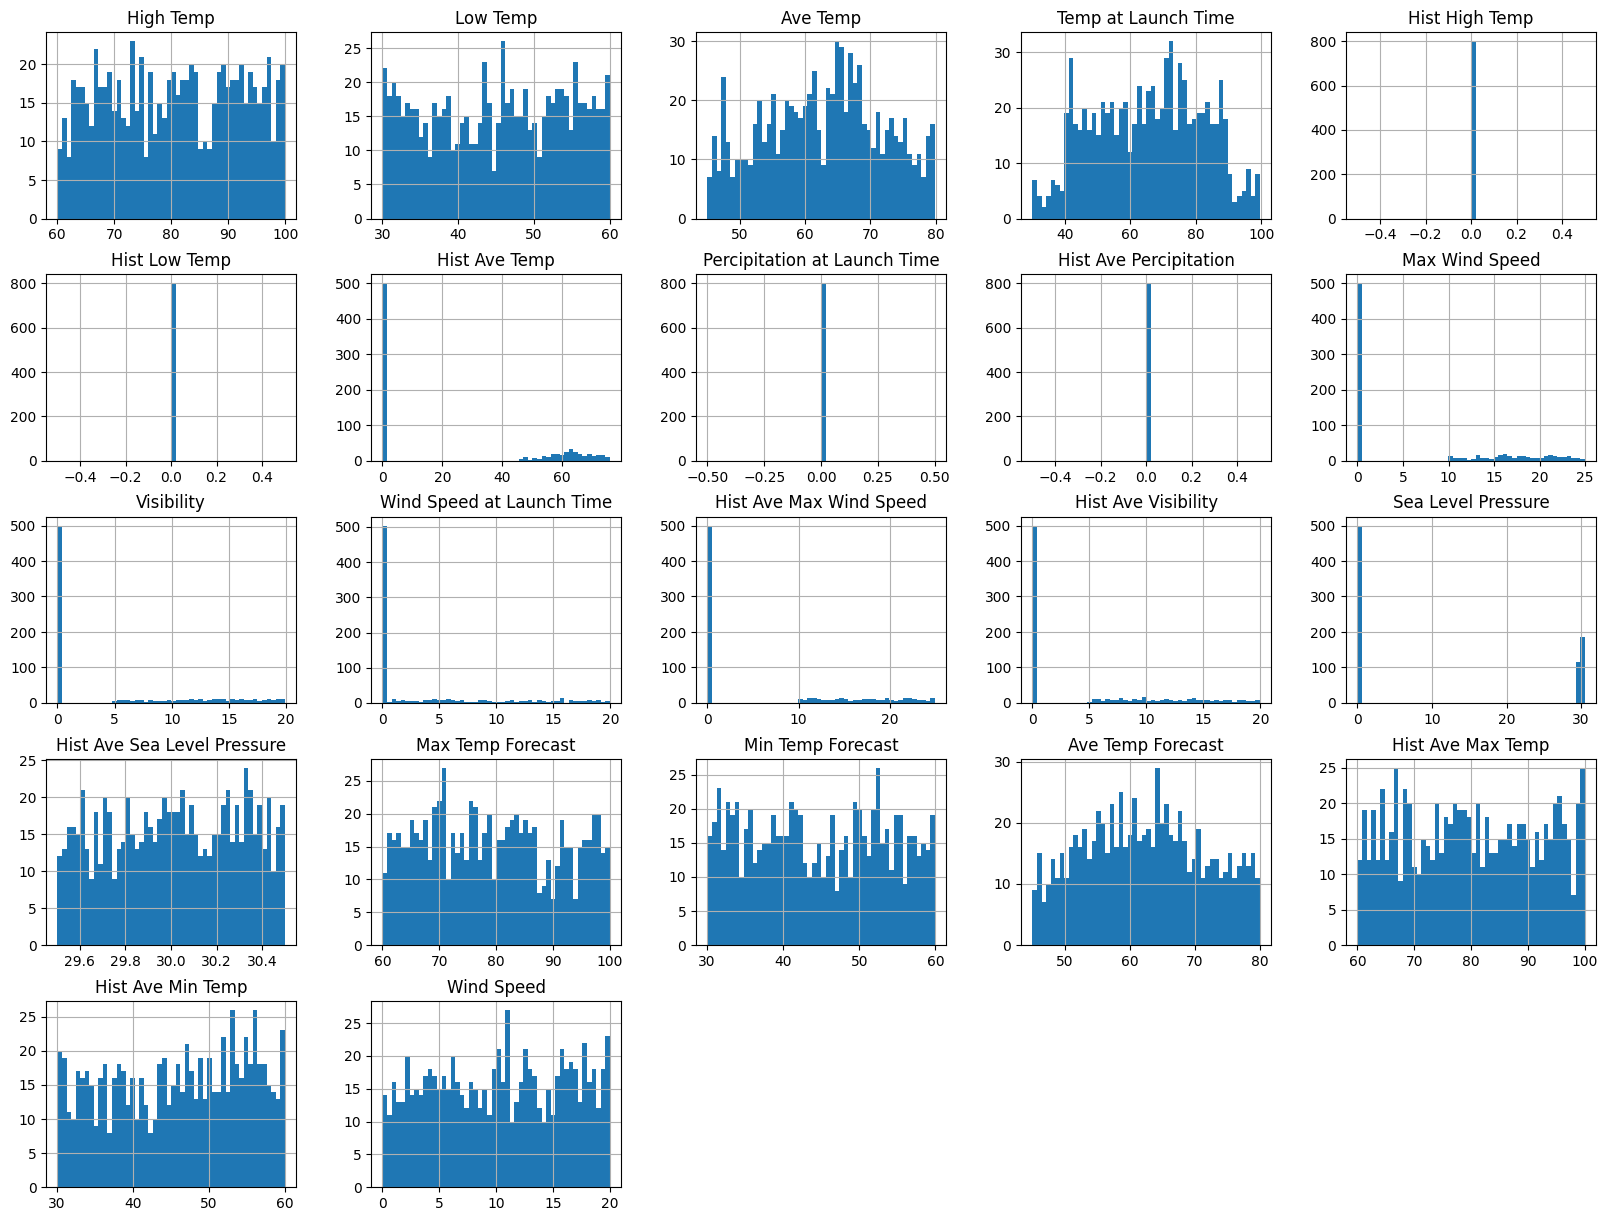

In [9]:


launch.hist(bins=50,figsize=(20,15))
plt.show()

In [10]:

launch=pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Clean_data.csv')

launch.columns



launch['Crewed or Uncrewed'] = launch['Crewed or Uncrewed'].map({'Uncrewed': 0, 'Crewed': 1})


label_encoder = LabelEncoder()

launch['Wind Direction'] = label_encoder.fit_transform(launch['Wind Direction'])
launch['Condition'] = label_encoder.fit_transform(launch['Condition'])


output_file_path = '/content/drive/MyDrive/DRDO/Extend_Encoded.csv'
launch.to_csv(output_file_path, index=False)


In [11]:
launch=pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')

launch.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Hist Ave Sea Level Pressure,Day Length,Condition,Notes,Max Temp Forecast,Min Temp Forecast,Ave Temp Forecast,Hist Ave Max Temp,Hist Ave Min Temp,Wind Speed
0,Gemini,01-Jan-00,00:00,Baikonur Cosmodrome,0,Y,75.150905,53.127341,64.139123,69.088887,...,30.133263,00:00,3,Successful launch,85.864237,49.082123,67.473180,76.804749,59.991414,14.499623
1,Saturn,02-Jan-00,01:00,Vandenberg AFB,1,N,73.497873,42.661082,58.079478,45.787810,...,29.950282,01:00,4,Delayed due to weather,66.990938,36.631901,51.811419,96.214395,34.515645,10.776260
2,Apollo,03-Jan-00,02:00,Cape Canaveral,0,Y,95.985896,40.616141,68.301019,41.257783,...,30.031109,02:00,0,Delayed due to weather,74.430901,59.351918,66.891410,89.586852,54.502708,1.212579
3,Saturn,04-Jan-00,03:00,Kennedy Space Center,0,Y,84.302209,58.758815,71.530512,75.606363,...,30.245718,03:00,3,0,96.235644,52.445757,74.340701,67.650417,36.219270,13.799995
4,Saturn,05-Jan-00,04:00,Cape Canaveral,0,N,69.774126,35.531128,52.652627,52.814782,...,30.325941,04:00,1,0,90.797788,46.734397,68.766092,84.551097,53.471650,13.801931


In [49]:

print(launch.isna().sum())

print(launch['Crewed or Uncrewed'].unique())
print(launch['Wind Direction'].unique())
print(launch['Condition'].unique())


Name                            0
Date                            0
Time (East Coast)               0
Location                        0
Crewed or Uncrewed              0
Launched?                       0
High Temp                       0
Low Temp                        0
Ave Temp                        0
Temp at Launch Time             0
Hist High Temp                  0
Hist Low Temp                   0
Hist Ave Temp                   0
Percipitation at Launch Time    0
Hist Ave Percipitation          0
Wind Direction                  0
Max Wind Speed                  0
Visibility                      0
Wind Speed at Launch Time       0
Hist Ave Max Wind Speed         0
Hist Ave Visibility             0
Sea Level Pressure              0
Hist Ave Sea Level Pressure     0
Day Length                      0
Condition                       0
Notes                           0
dtype: int64
[0 1]
[0 2 1 5 8 3 4 6 7]
[ 0  6  4  1 10  8  7  9  5  3  2]


In [13]:
y=launch['Launched?']

launch.drop(['Name', 'Date', 'Time (East Coast)', 'Location', 'Launched?', 'Hist Ave Sea Level Pressure', 'Sea Level Pressure', 'Day Length', 'Notes', 'Hist Ave Max Wind Speed'], axis = 1, inplace=True) #Save remaining data as input data
X = launch

X.columns

tree_model = DecisionTreeClassifier(random_state=0, max_depth=5)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=99)
tree_model.fit(X_train, y_train)


y_pred=tree_model.predict(X_test)
print("Prediction on test data: \n", y_pred)
print("\n Acuuracy: \n",tree_model.score(X_test,y_test))

Prediction on test data: 
 ['N' 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y'
 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'N' 'Y' 'N' 'N'
 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'N' 'N' 'N' 'Y' 'Y'
 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y'
 'N' 'Y' 'N' 'Y' 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'Y' 'N' 'Y'
 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y']

 Acuuracy: 
 0.43125


Model


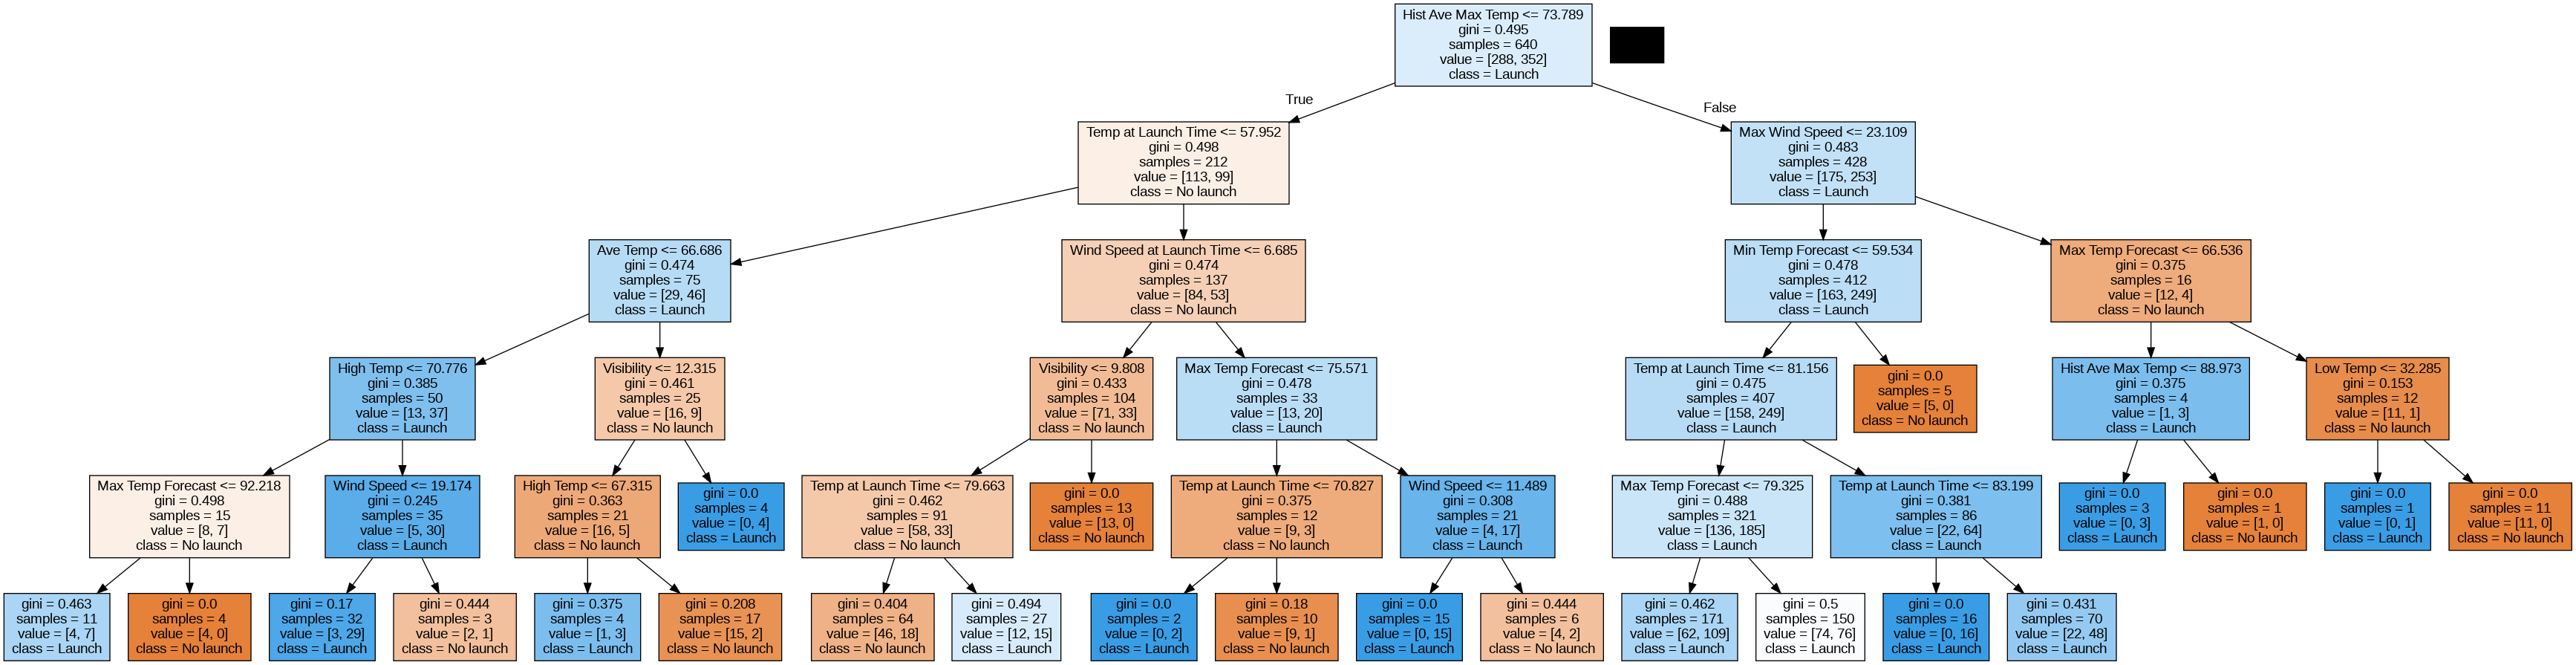

In [14]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
  tree_str = export_graphviz(tree, feature_names=feature_names,class_names=['No launch','Launch'], filled=True, out_file=None)
  graph=pydotplus.graph_from_dot_data(tree_str)
  graph.write_png(png_file_to_save)

  return Image(graph.create_png())

print("Model")
tree_graph_to_png(tree=tree_model, feature_names=X.columns.values,png_file_to_save='tree.png')

In [15]:
import pandas as pd

def replace_and_convert(df, column_name='Sea Level Pressure',
                          old_value='20:52', new_value=20.52):
    """Replaces a specific string value and converts the column to floats.

    Args:
        df (pd.DataFrame): The Pandas DataFrame.
        column_name (str): Name of the column to process.
        old_value (str): The specific string value to replace.
        new_value (float): The numerical value to replace the old string with.

    Returns:
        pd.DataFrame: The DataFrame with the replaced and converted column.
    """

    df[column_name] = df[column_name].replace(old_value, str(new_value))
    df[column_name] = df[column_name].astype(float)
    return df


launch = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')
launch = replace_and_convert(launch, 'Sea Level Pressure', '20:52', 20.52)
print(launch['Sea Level Pressure'].unique())
launch.to_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv', index=False)


[30.30771782 30.385914   30.31607904 29.5189454  30.23591795 29.70839957
 29.63292804 30.13848878 29.8197432  29.55711716 29.63762973 29.50092942
 30.40322363 29.52461798 29.70945577 29.91626278 29.85657133 30.41172588
 29.54028895 30.01221471 30.18047946 30.43169797 30.12037125 30.30375524
 29.58372494 29.88593951 29.87394713 30.38628822 29.65137117 29.65188617
 29.82855815 29.55446605 29.68245804 30.46520964 29.92818394 30.13201921
 30.22611126 29.86696141 29.64722707 29.70658102 29.81326648 30.13606842
 29.89828055 29.5068147  30.02340719 30.42151339 30.31207761 30.32521137
 30.29505802 29.82373083 30.26519383 29.64316136 30.15771615 30.14156857
 29.5255698  30.28797013 30.40324811 29.76741528 30.31239072 29.58240597
 30.09996786 29.98564687 30.04592353 30.4262052  30.37131525 30.28508366
 29.77369846 30.41181863 29.59750769 30.35332922 29.82816007 29.55377231
 30.16935698 29.73127993 29.74357113 29.80604717 29.56368477 29.67712714
 29.50513963 29.94540952 29.58425538 30.18265261 29

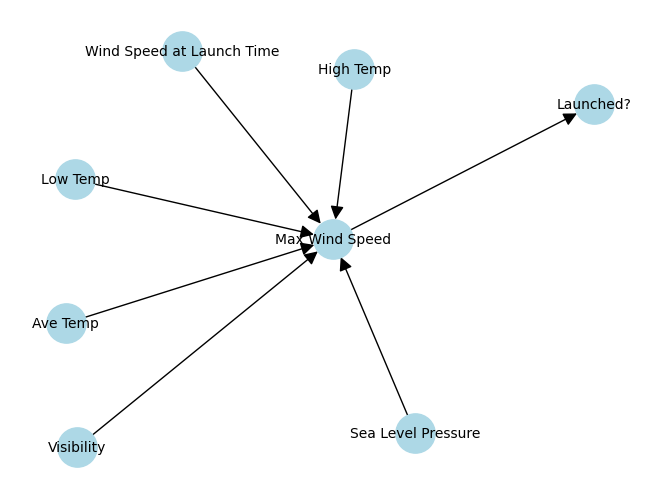

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_mode

Causal Estimate for Max Wind Speed: -0.0026801170634765392


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

Refute: Use a Placebo Treatment
Estimated effect:-0.0026801170634765392
New effect:0.0
p value:1.0



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

In [25]:
import pandas as pd
import dowhy
from dowhy import CausalModel
import networkx as nx
import matplotlib.pyplot as plt

launch = pd.read_csv('/content/drive/MyDrive/DRDO/Encoded.csv')
launch['Launched?'] = launch['Launched?'].map({'Y': 1, 'N': 0})

# Define the treatment, outcome, and common causes
treatment = 'Max Wind Speed' # Corrected treatment variable
outcome = 'Launched?'
common_causes = ['High Temp', 'Ave Temp', 'Low Temp', 'Temp at Launch Time', 'Visibility',
                   'Wind Speed at Launch Time', 'Sea Level Pressure']

# **Define the causal graph (adapt this based on your knowledge)**
causal_graph = nx.DiGraph([('High Temp', 'Max Wind Speed'), ('Ave Temp', 'Max Wind Speed'),
                           ('Low Temp', 'Max Wind Speed'), ('Visibility', 'Max Wind Speed'),
                           ('Wind Speed at Launch Time', 'Max Wind Speed'),
                           ('Sea Level Pressure', 'Max Wind Speed'),
                           ('Max Wind Speed', 'Launched?')])  # Use 'Max Wind Speed'

# Visualize the causal graph (optional)
nx.draw(causal_graph, with_labels=True, node_color="lightblue",
         arrowsize=20, node_size=800, font_size=10)
plt.show()

# Create the causal model with the defined graph
model = CausalModel(
    data=launch,
    treatment=treatment,
    outcome=outcome,
    graph=causal_graph
)

# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the causal effect
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 target_units="ate")

print(f"Causal Estimate for {treatment}:", estimate.value)

# Refute the estimate
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

In [27]:

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


launch = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')



y = launch['Launched?']
X = launch[['Max Wind Speed', 'High Temp', 'Ave Temp', 'Low Temp', 'Temp at Launch Time', 'Visibility',
            'Wind Speed at Launch Time', 'Sea Level Pressure']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


logit_model = LogisticRegression(max_iter=1000, solver='liblinear')
logit_model.fit(X_train, y_train)

coefficients = logit_model.coef_

feature_names = ['Max Wind Speed', 'High Temp', 'Ave Temp', 'Low Temp', 'Temp at Launch Time', 'Visibility', 'Wind Speed at Launch Time', 'Sea Level Pressure']
for name, coef in zip(feature_names, coefficients[0]):
    print(f'{name}: {coef}')

y_pred = logit_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Max Wind Speed: -0.37110840384886357
High Temp: -0.04138431938267934
Ave Temp: 0.011948635099368844
Low Temp: 0.003125115231339114
Temp at Launch Time: 0.018251832188138264
Visibility: 0.06426188858618413
Wind Speed at Launch Time: 0.25620816600960217
Sea Level Pressure: 0.12005068388733031
Accuracy: 0.51


In [28]:

from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML


launch = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')

launch['Launched?'] = launch['Launched?'].map({'Y': 1, 'N': 0})  # Convert 'Y'/'N' to 1/0 for binary classification


y = launch['Launched?']
X = launch[['High Temp', 'Ave Temp', 'Low Temp', 'Temp at Launch Time', 'Visibility', 'Wind Speed at Launch Time', 'Sea Level Pressure']]


T = launch[['Max Wind Speed']]


X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, y, T, test_size=0.2, random_state=99)


scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
T_train = scaler_T.fit_transform(T_train)
T_test = scaler_T.transform(T_test)

y_train = y_train.values.ravel()


T_train = T_train.ravel()


estimator = LinearDML(model_y='auto', model_t='auto', discrete_treatment=False)

estimator.fit(Y=y_train, T=T_train, X=X_train)

ate = estimator.ate(X=X_test)
ate_lower, ate_upper = estimator.ate_interval(X=X_test)

print(f'ATE: {ate}')
print(f'ATE 95% CI: [{ate_lower}, {ate_upper}]')

ite = estimator.effect(X=X_test)


print(f'Sample ITEs: {ite[:5]}')




ATE: 0.6136788261216684
ATE 95% CI: [-0.4031047343585761, 1.6304623866019126]
Sample ITEs: [-1.82294934 -0.4349273   0.08616058  1.75350848  0.22807066]


In [29]:

from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML

launch = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')


launch['Launched?'] = launch['Launched?'].map({'Y': 1, 'N': 0})

y = launch['Launched?']
X = launch[['High Temp', 'Ave Temp', 'Low Temp', 'Visibility', 'Wind Speed at Launch Time', 'Sea Level Pressure']]  # Features


T_wind = launch[['Max Wind Speed']]
T_temp = launch[['Temp at Launch Time']]


X_train, X_test, y_train, y_test, T_wind_train, T_wind_test, T_temp_train, T_temp_test = train_test_split(
    X, y, T_wind, T_temp, test_size=0.2, random_state=99)

scaler_X = StandardScaler()
scaler_T_wind = StandardScaler()
scaler_T_temp = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
T_wind_train = scaler_T_wind.fit_transform(T_wind_train)
T_wind_test = scaler_T_wind.transform(T_wind_test)
T_temp_train = scaler_T_temp.fit_transform(T_temp_train)
T_temp_test = scaler_T_temp.transform(T_temp_test)


y_train = y_train.values.ravel()

T_wind_train = T_wind_train.ravel()
T_temp_train = T_temp_train.ravel()


estimator_wind = LinearDML(model_y='auto', model_t='auto', discrete_treatment=False)
estimator_wind.fit(Y=y_train, T=T_wind_train, X=X_train)
ate_wind = estimator_wind.ate(X=X_test)
ate_wind_lower, ate_wind_upper = estimator_wind.ate_interval(X=X_test)
print(f'ATE for Max Wind Speed: {ate_wind}')
print(f'ATE for Max Wind Speed 95% CI: [{ate_wind_lower}, {ate_wind_upper}]')

estimator_temp = LinearDML(model_y='auto', model_t='auto', discrete_treatment=False)
estimator_temp.fit(Y=y_train, T=T_temp_train, X=X_train)
ate_temp = estimator_temp.ate(X=X_test)
ate_temp_lower, ate_temp_upper = estimator_temp.ate_interval(X=X_test)
print(f'ATE for Temperature at Launch Time: {ate_temp}')
print(f'ATE for Temperature at Launch Time 95% CI: [{ate_temp_lower}, {ate_temp_upper}]')

ite_wind = estimator_wind.effect(X=X_test)
ite_temp = estimator_temp.effect(X=X_test)

print(f'Sample ITEs for Max Wind Speed: {ite_wind[:5]}')
print(f'Sample ITEs for Temperature at Launch Time: {ite_temp[:5]}')


ATE for Max Wind Speed: 0.4776496085111626
ATE for Max Wind Speed 95% CI: [-0.7730564394448001, 1.7283556564671247]
ATE for Temperature at Launch Time: 0.0029309413348027127
ATE for Temperature at Launch Time 95% CI: [-0.0371068628916485, 0.042968745561253914]
Sample ITEs for Max Wind Speed: [ 0.5144893  -0.29046036  0.04029982  0.83116353  0.06859989]
Sample ITEs for Temperature at Launch Time: [ 0.04220987  0.10068886  0.07634291 -0.00947188 -0.02932538]


In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import shap

# Load your data (assuming it's in a DataFrame named df)
df = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')  # Replace with your data source

# Convert categorical variables to numeric
label_encoders = {}
categorical_columns = ['Name', 'Location', 'Crewed or Uncrewed', 'Launched?', 'Wind Direction', 'Condition', 'Notes']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define a function to try parsing dates in multiple formats
def parse_date(date):
    for fmt in ('%d-%b-%y', '%d-%b-%Y', '%Y-%m-%d'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT (Not a Time) if no format matches

# Convert Date and Time to numerical
df['Date'] = df['Date'].apply(parse_date)
df['Date'] = df['Date'].apply(lambda x: x.toordinal() if pd.notnull(x) else None)  # Convert to ordinal, handle NaT
df['Time (East Coast)'] = pd.to_datetime(df['Time (East Coast)'], format='%H:%M', errors='coerce').dt.hour  # Convert time to hour

# Drop rows with NaT in Date column (if any) after conversion
df.dropna(subset=['Date'], inplace=True)

# Selecting relevant features
features = ['Date', 'Time (East Coast)', 'Ave Temp', 'Max Wind Speed', 'Visibility', 'Sea Level Pressure']
target = 'Launched?'

# Preparing feature and target variables
X = df[features]
y = df[target]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediction on new data
new_data = pd.DataFrame({
    'Date': [737791],  # Example date as ordinal
    'Time (East Coast)': [15],  # Example time in hours (3 PM)
    'Ave Temp': [25.0],  # Example average temperature
    'Max Wind Speed': [15.0],  # Example max wind speed
    'Visibility': [10.0],  # Example visibility
    'Sea Level Pressure': [1015.0]  # Example sea level pressure
})
prediction = clf.predict(new_data)
print(f'Prediction: {"Launched" if prediction[0] else "Not Launched"}')

# Explainable AI (XAI) with SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# Visualize the SHAP values for the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X.iloc[0])


Prediction: Not Launched


Initial Data:
     Name       Date Time (East Coast)              Location  \
0  Gemini  01-Jan-00             00:00   Baikonur Cosmodrome   
1  Saturn  02-Jan-00             01:00        Vandenberg AFB   
2  Apollo  03-Jan-00             02:00        Cape Canaveral   
3  Saturn  04-Jan-00             03:00  Kennedy Space Center   
4  Saturn  05-Jan-00             04:00        Cape Canaveral   

   Crewed or Uncrewed Launched?  High Temp   Low Temp   Ave Temp  \
0                   0         Y  75.150905  53.127341  64.139123   
1                   1         N  73.497873  42.661082  58.079478   
2                   0         Y  95.985896  40.616141  68.301019   
3                   0         Y  84.302209  58.758815  71.530512   
4                   0         N  69.774126  35.531128  52.652627   

   Temp at Launch Time  ...  Hist Ave Sea Level Pressure  Day Length  \
0            69.088887  ...                    30.133263       00:00   
1            45.787810  ...                    2

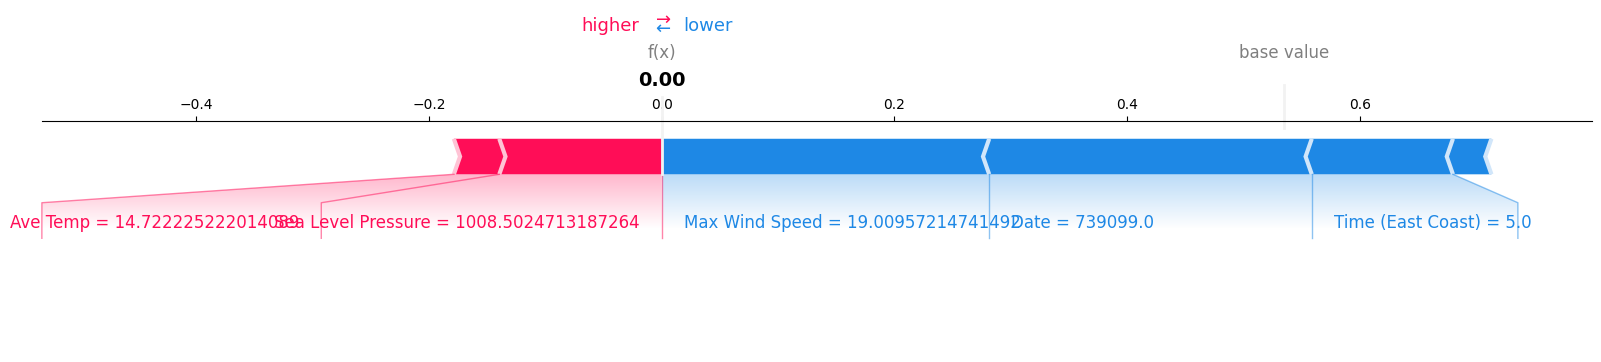

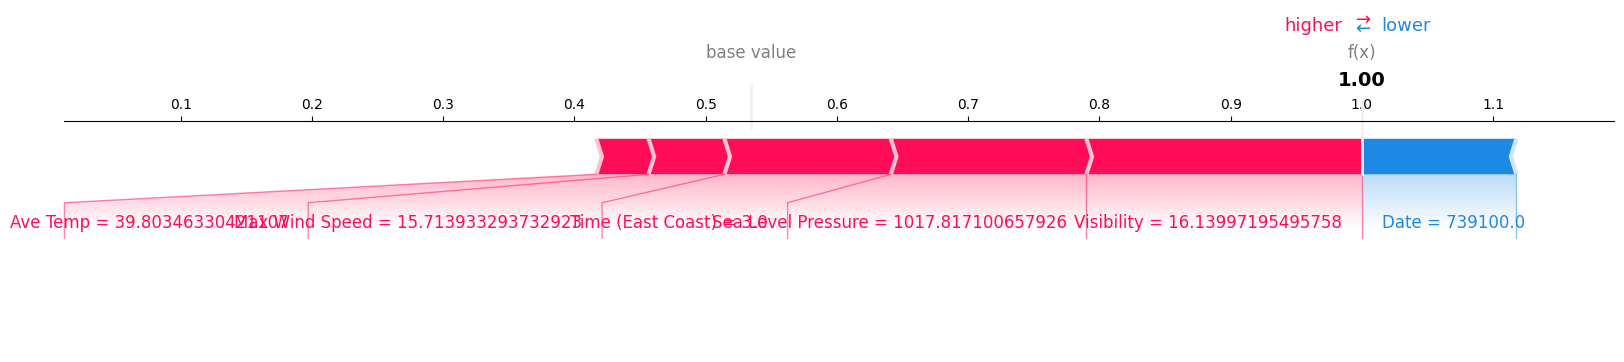

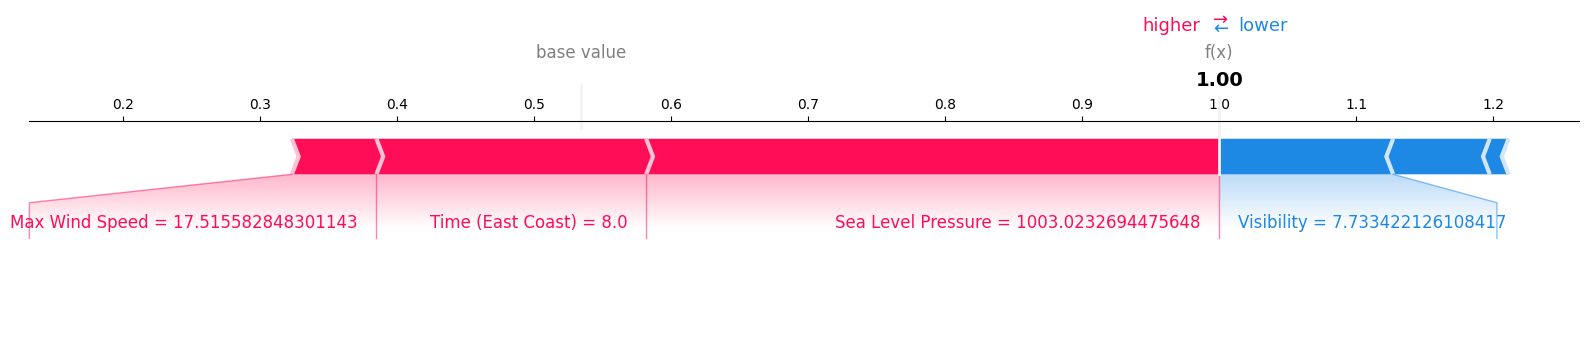

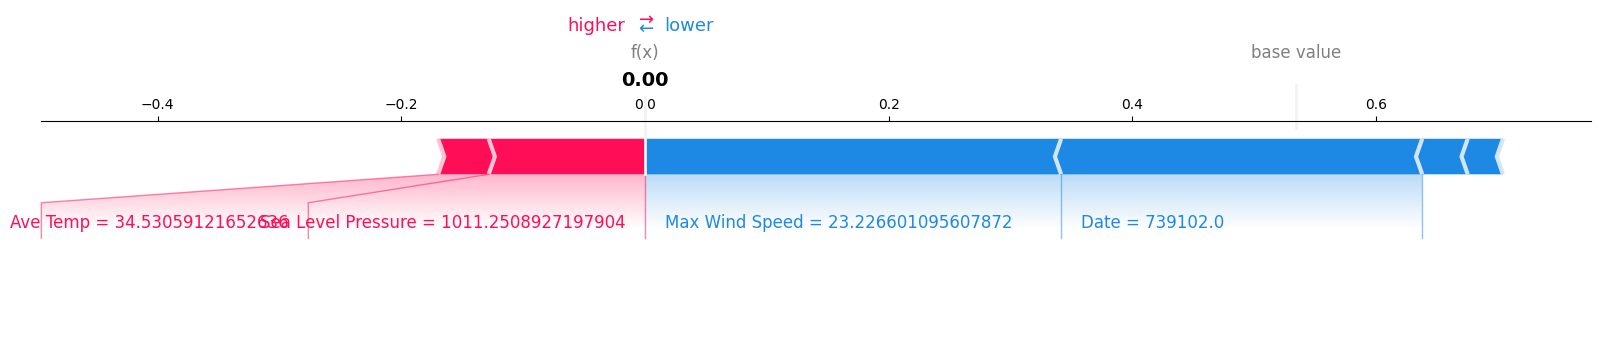

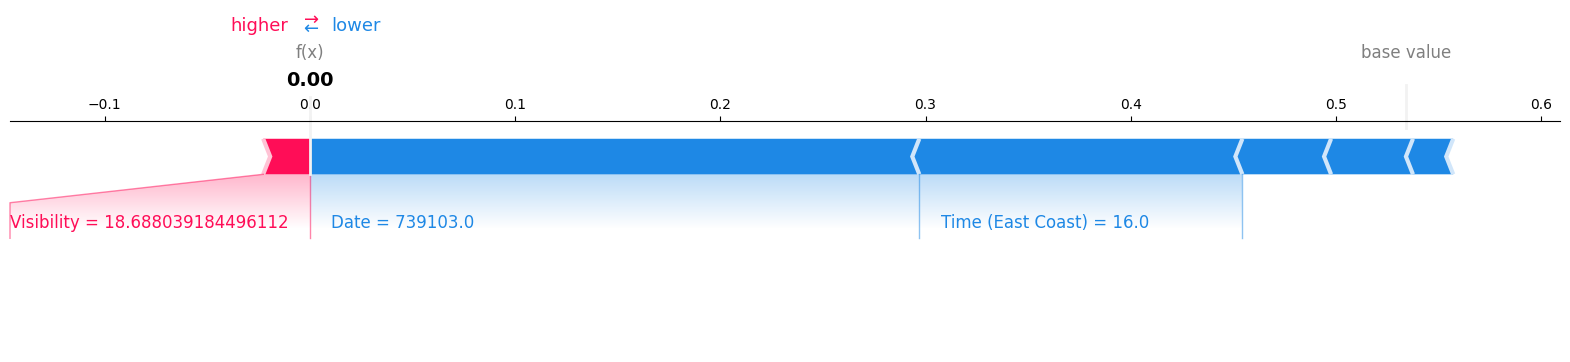

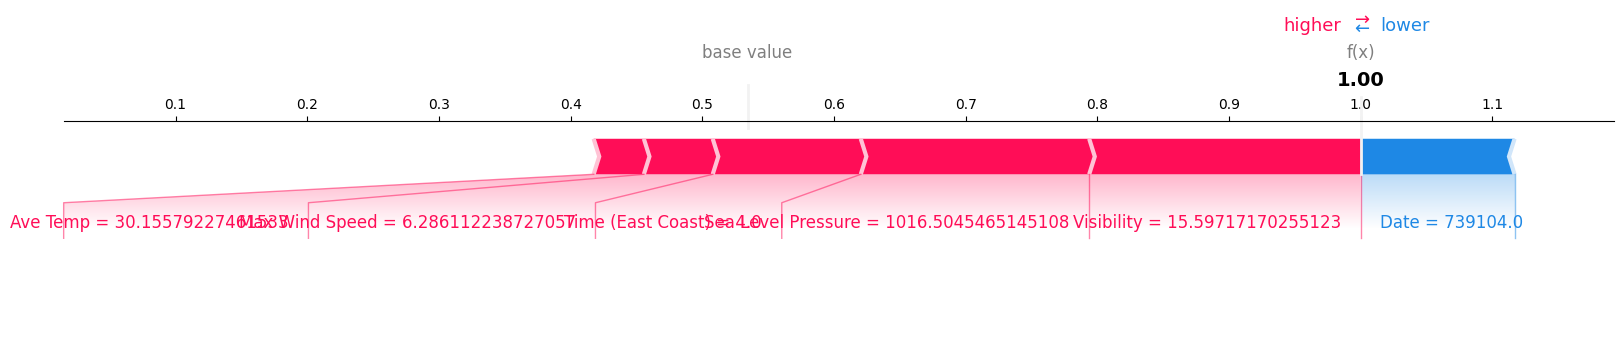

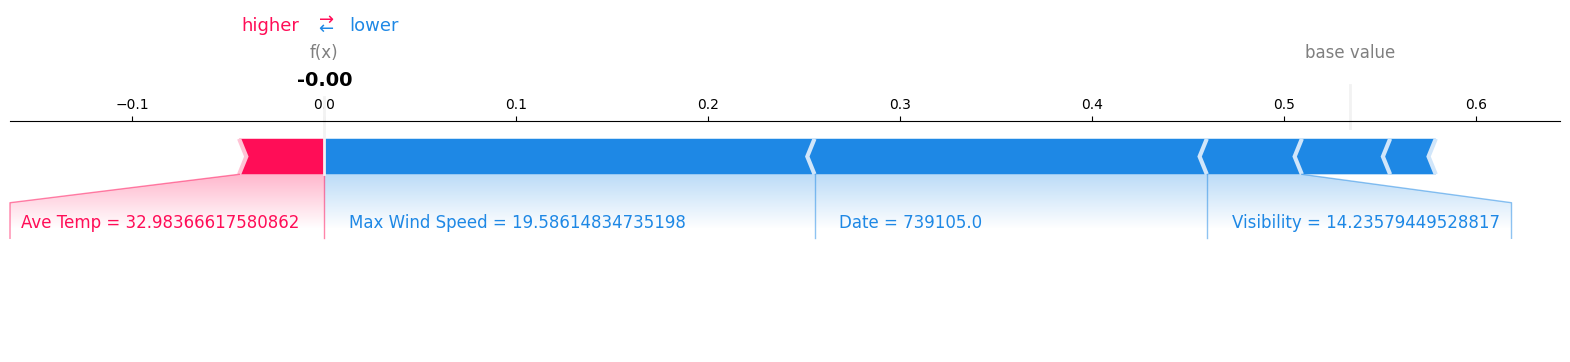

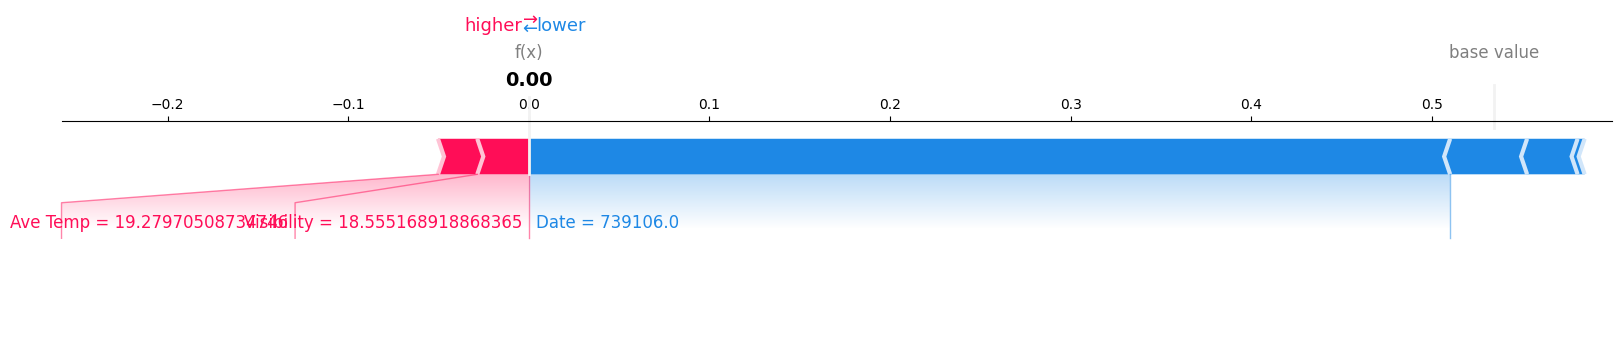

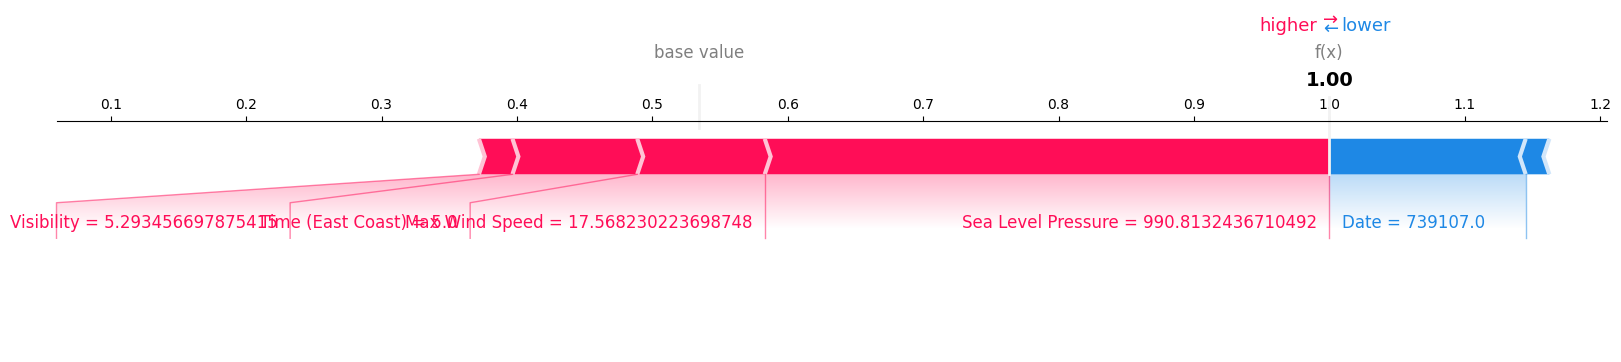

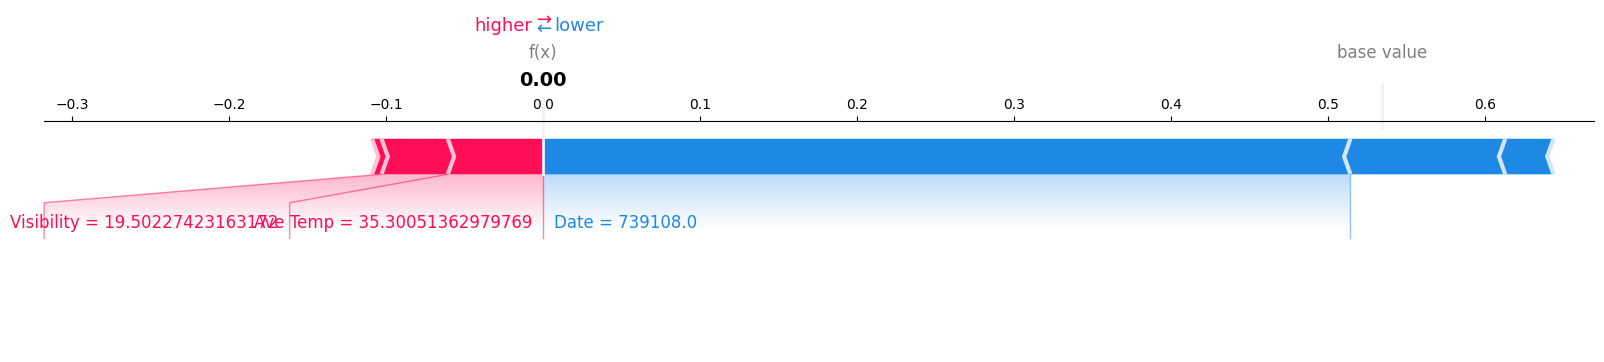

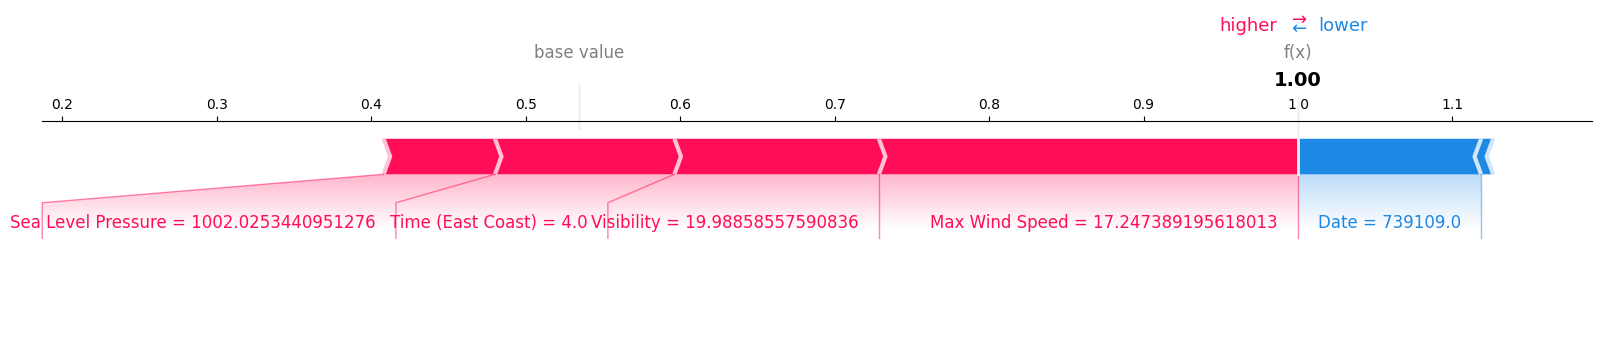

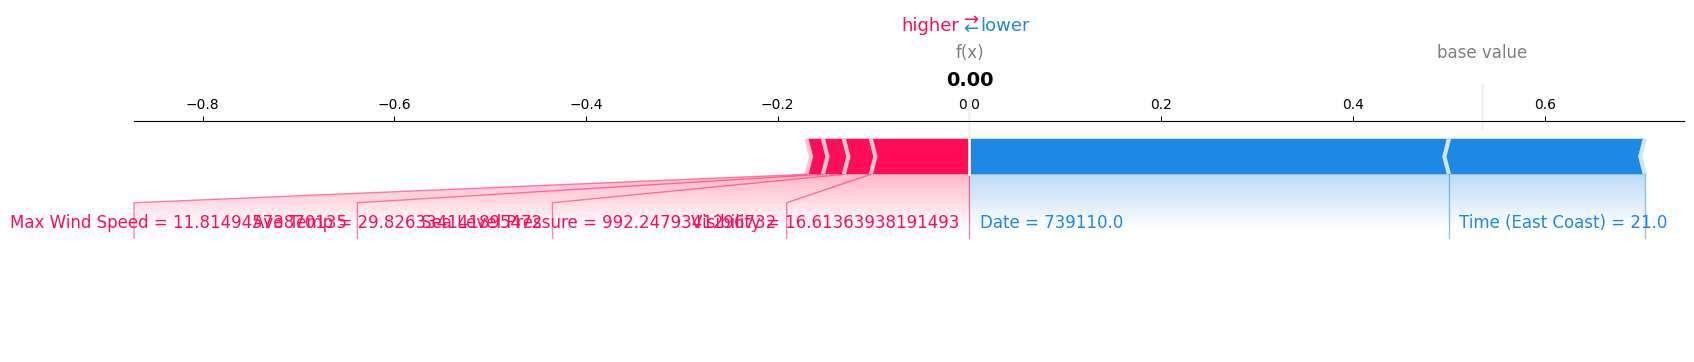

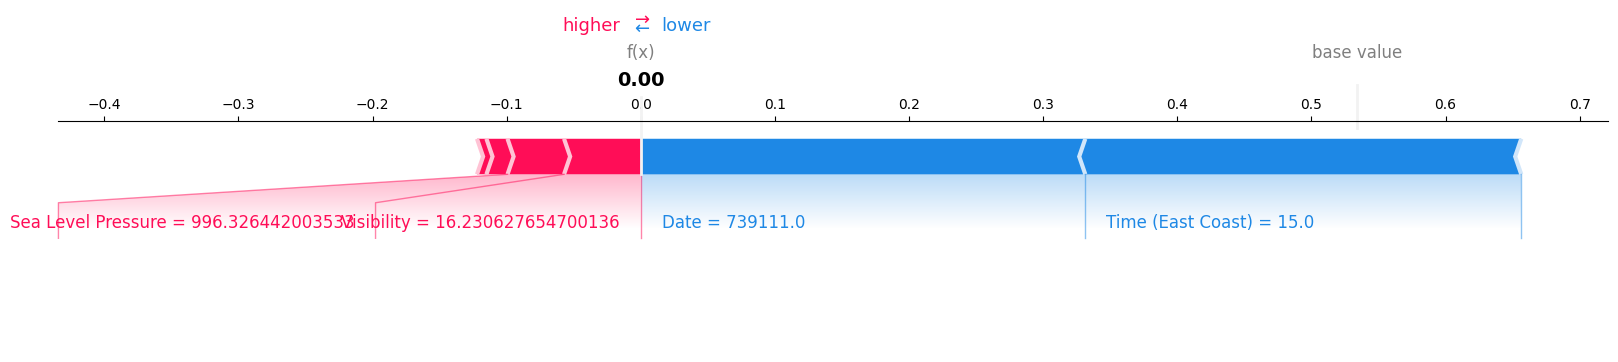

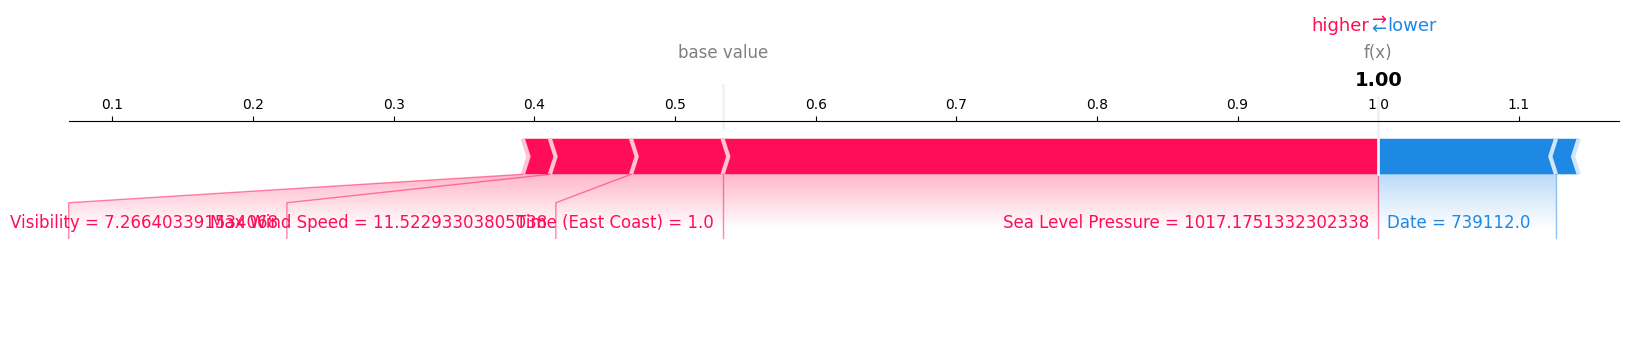

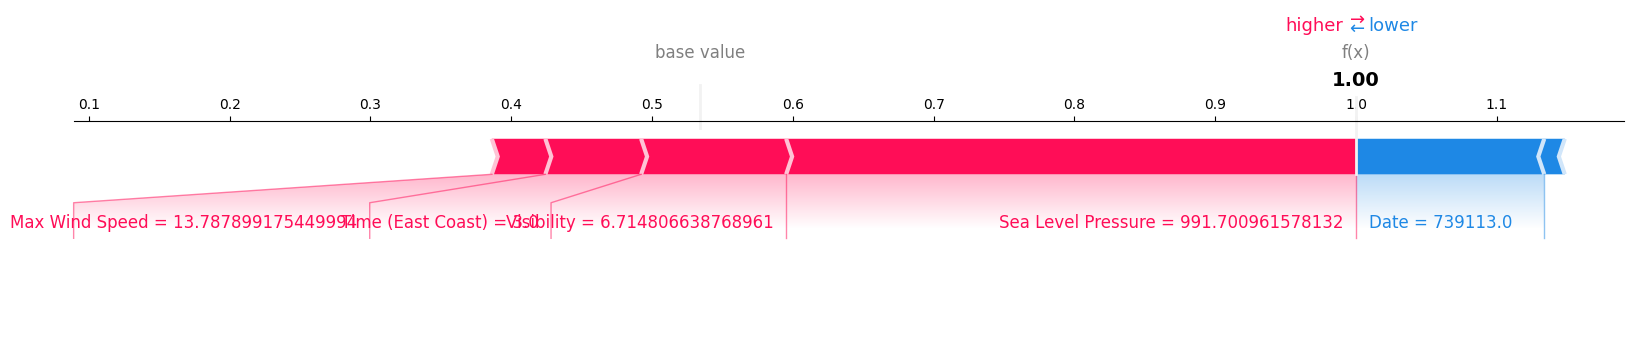

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import shap

# Load existing data for training the model
df = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')

# Check the initial data
print("Initial Data:")
print(df.head())

# Convert 'Launched?' column to binary and drop rows with NaN in 'Launched?'
df['Launched?'] = df['Launched?'].map({'Y': 1, 'N': 0})
df = df.dropna(subset=['Launched?'])

# Define a function to parse dates
def parse_date(date):
    for fmt in ('%d-%b-%y', '%d-%b-%Y', '%Y-%m-%d'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Convert 'Date' to numeric ordinal
df['Date'] = df['Date'].apply(parse_date).apply(lambda x: x.toordinal() if pd.notnull(x) else None)

# Convert 'Time (East Coast)' to hours
df['Time (East Coast)'] = pd.to_datetime(df['Time (East Coast)'], format='%H:%M', errors='coerce').dt.hour

# Debug print to check the data after date and time conversion
print("Data after date and time conversion:")
print(df.head())

# Drop rows with NaT in Date or Time columns (if any) after conversion
df.dropna(subset=['Date', 'Time (East Coast)'], inplace=True)

# Debug print to check the preprocessed data
print("Preprocessed Data:")
print(df.head())

# Selecting relevant features
features = ['Date', 'Time (East Coast)', 'Ave Temp', 'Max Wind Speed', 'Visibility', 'Sea Level Pressure']
target = 'Launched?'

# Preparing feature and target variables
X = df[features]
y = df[target]

# Debug print to check X and y
print("Features (X):")
print(X.head())
print("Target (y):")
print(y.head())

# Ensure there are no missing values in X and y
print("Missing values in X:")
print(X.isnull().sum())
print("Missing values in y:")
print(y.isnull().sum())

# Splitting the data
if not X.empty and not y.empty:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check sizes of the splits
    print("Training set size:", X_train.shape, y_train.shape)
    print("Test set size:", X_test.shape, y_test.shape)

    # Train Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Load your new data from the specified path
    df_new = pd.read_csv('/content/drive/MyDrive/DRDO/launch_prediction_input.csv')

    # Drop the 'Percipitation at Launch Time' column
    df_new.drop(columns=['Percipitation at Launch Time'], inplace=True)

    # Debug print to check the new data
    print("New Data:")
    print(df_new.head())

    # Ensure new data contains only the features the model was trained on
    df_new_features = df_new[features]

    # Predictions on the new data
    if not df_new_features.empty:
        predictions = clf.predict(df_new_features)

        # Add predictions to the new dataframe
        df_new['Predictions'] = predictions

        # Print predictions
        print("Predictions on New Data:")
        print(df_new[['Date', 'Time (East Coast)', 'Predictions']])

        # Explainable AI (XAI) with SHAP
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(df_new_features)

        # Visualize the SHAP values for each prediction
        shap.initjs()
        for i in range(len(df_new)):
            shap.force_plot(explainer.expected_value[1], shap_values[1][i], df_new_features.iloc[i], matplotlib=True)
    else:
        print("Error: No new data available after preprocessing.")
else:
    print("Error: No data available after preprocessing.")


Initial Data:
     Name       Date Time (East Coast)              Location  \
0  Gemini  01-Jan-00             00:00   Baikonur Cosmodrome   
1  Saturn  02-Jan-00             01:00        Vandenberg AFB   
2  Apollo  03-Jan-00             02:00        Cape Canaveral   
3  Saturn  04-Jan-00             03:00  Kennedy Space Center   
4  Saturn  05-Jan-00             04:00        Cape Canaveral   

   Crewed or Uncrewed Launched?  High Temp   Low Temp   Ave Temp  \
0                   0         Y  75.150905  53.127341  64.139123   
1                   1         N  73.497873  42.661082  58.079478   
2                   0         Y  95.985896  40.616141  68.301019   
3                   0         Y  84.302209  58.758815  71.530512   
4                   0         N  69.774126  35.531128  52.652627   

   Temp at Launch Time  ...  Hist Ave Sea Level Pressure  Day Length  \
0            69.088887  ...                    30.133263       00:00   
1            45.787810  ...                    2


SHAP values for prediction 1:


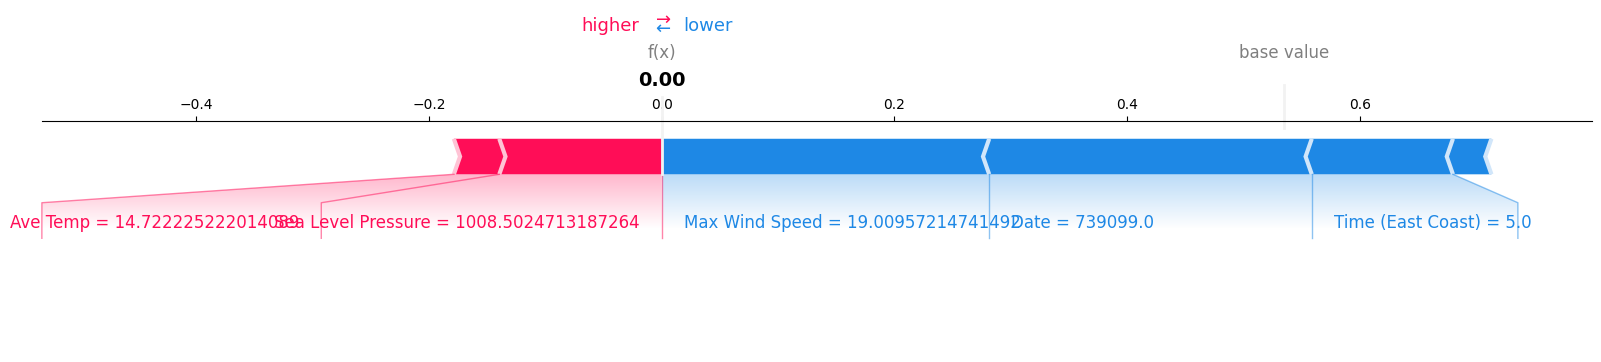


SHAP values for prediction 2:


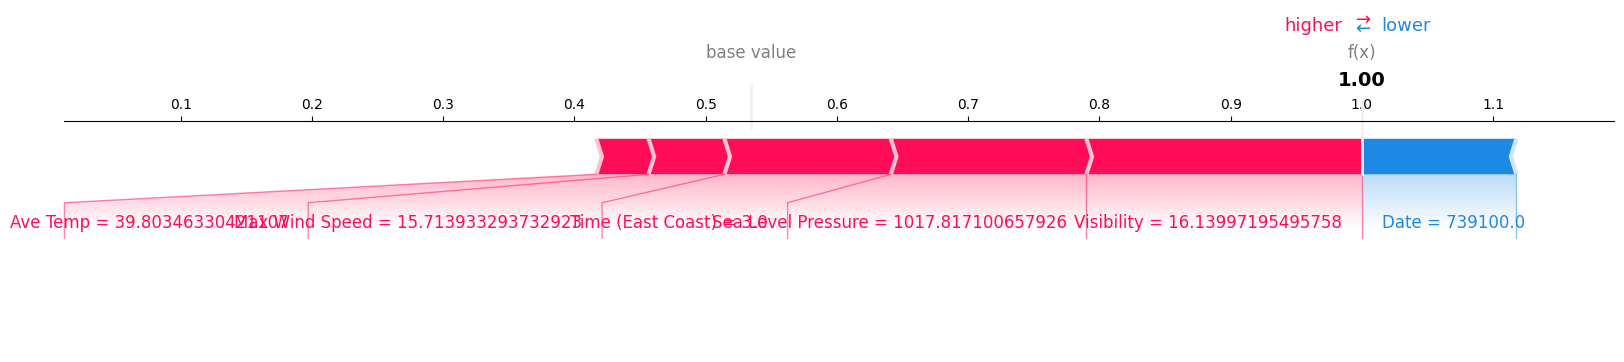


SHAP values for prediction 3:


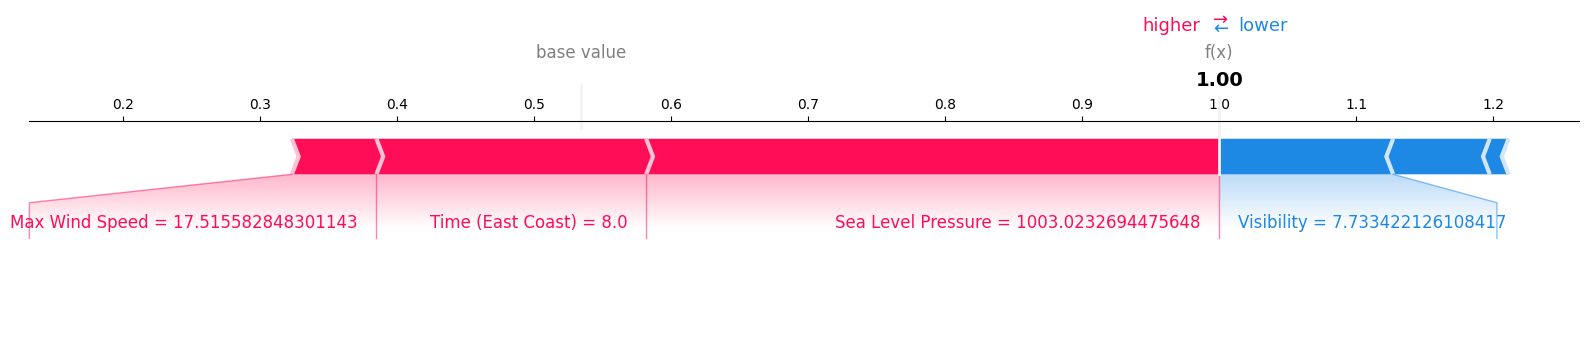


SHAP values for prediction 4:


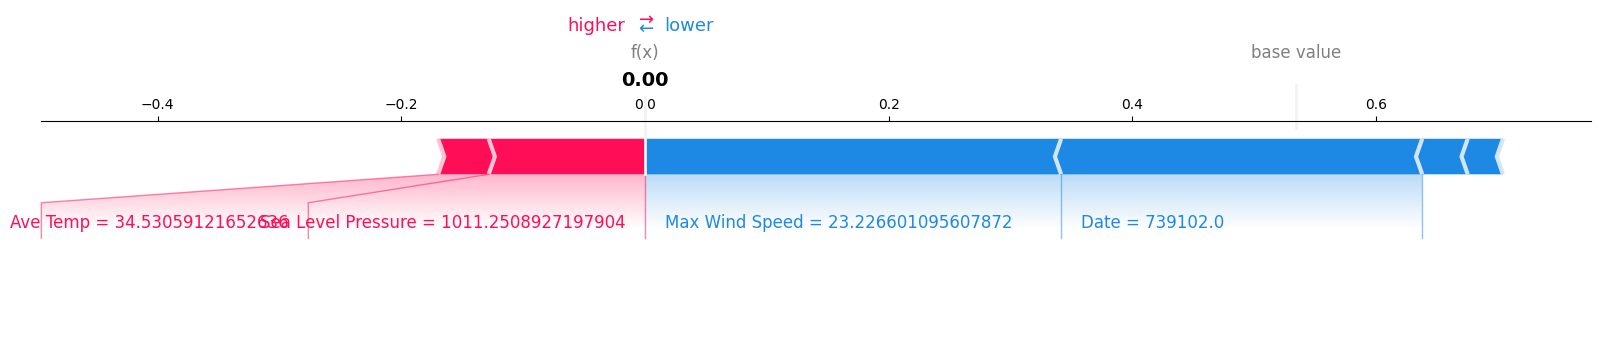


SHAP values for prediction 5:


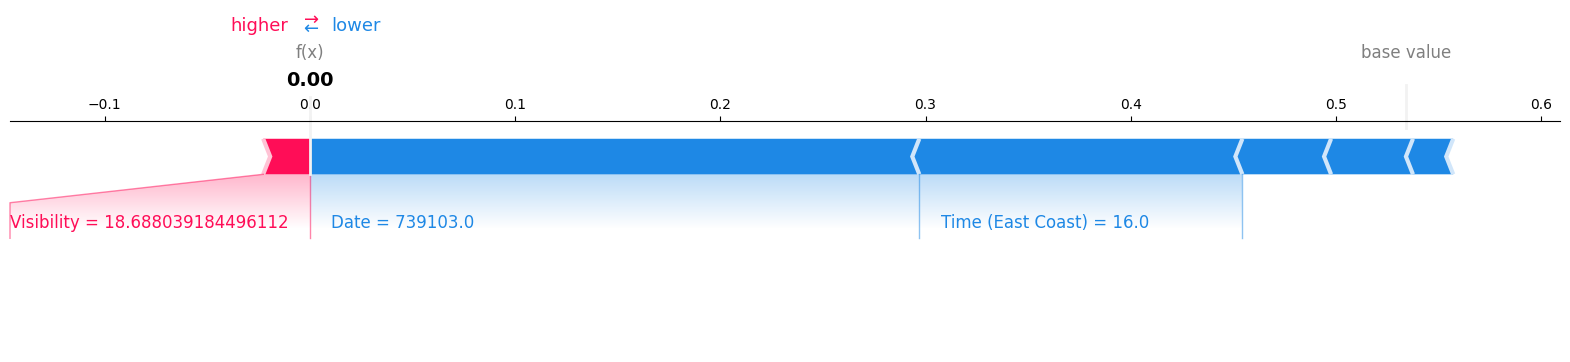


SHAP values for prediction 6:


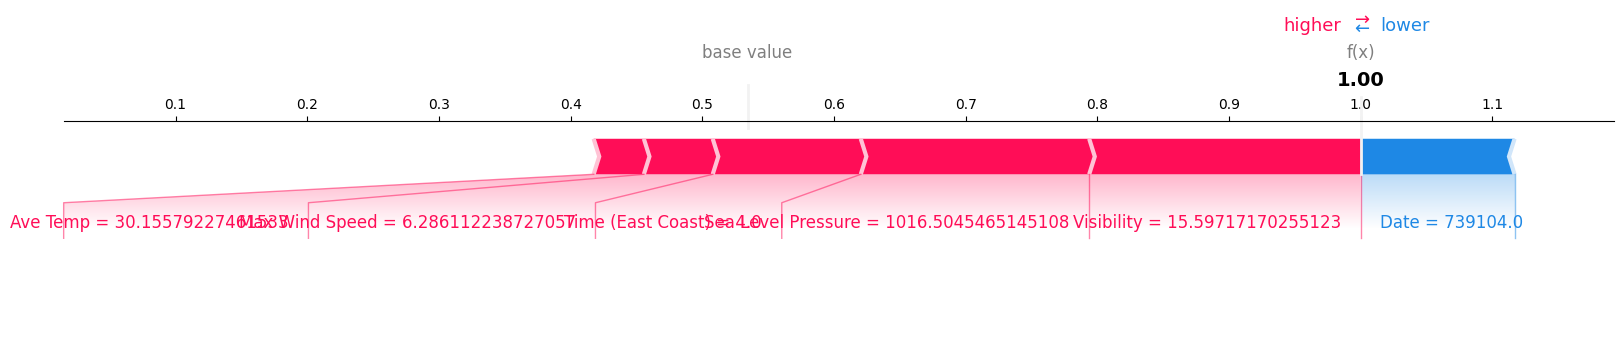


SHAP values for prediction 7:


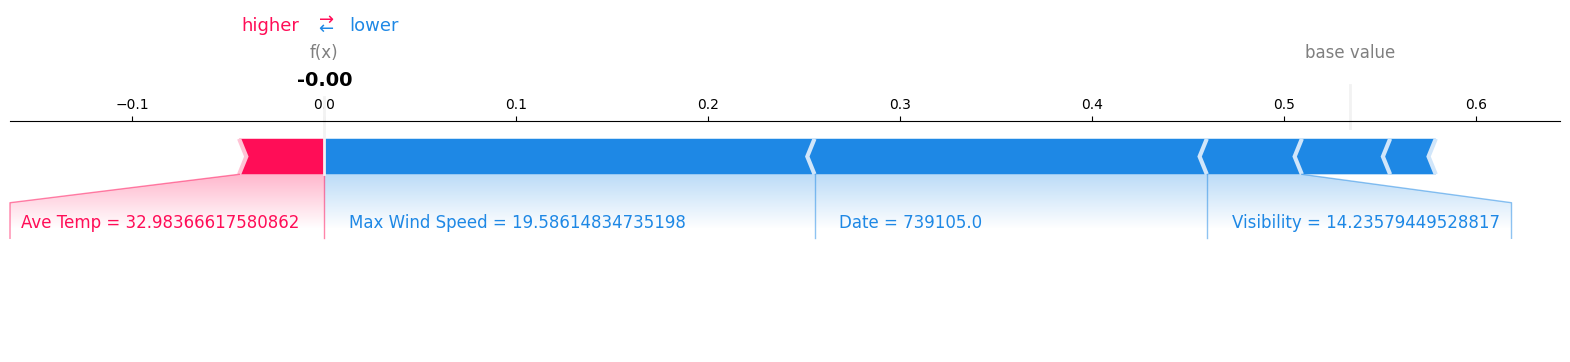


SHAP values for prediction 8:


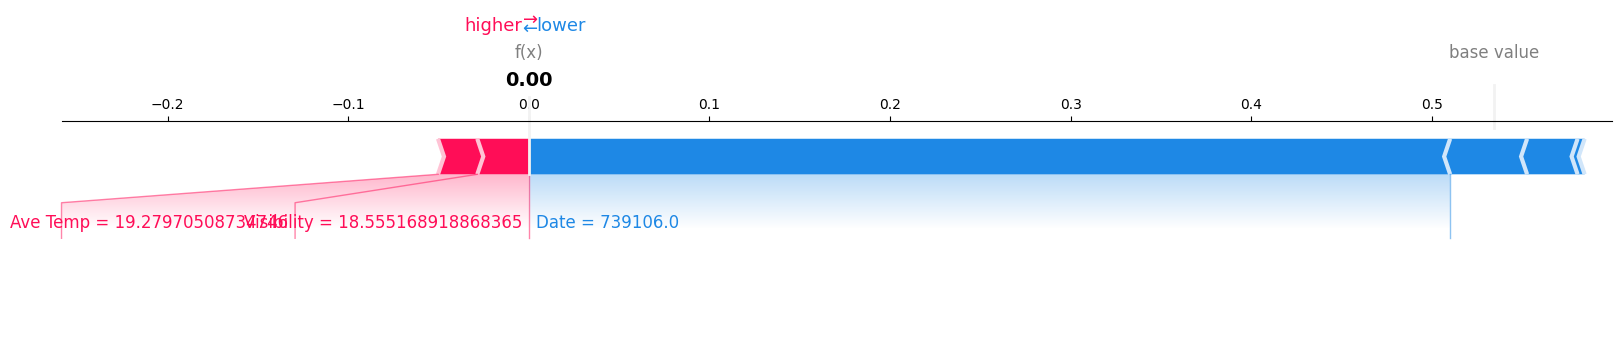


SHAP values for prediction 9:


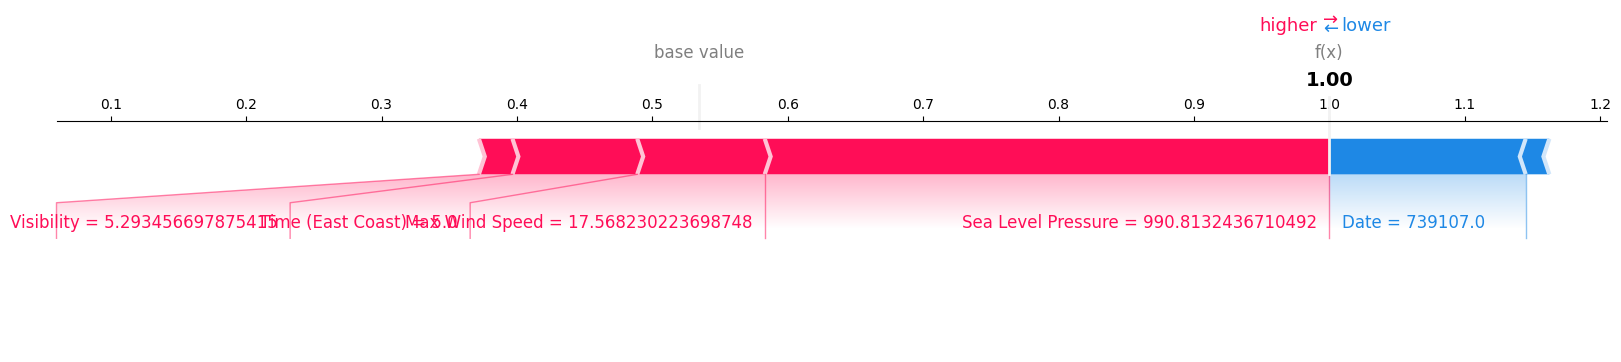


SHAP values for prediction 10:


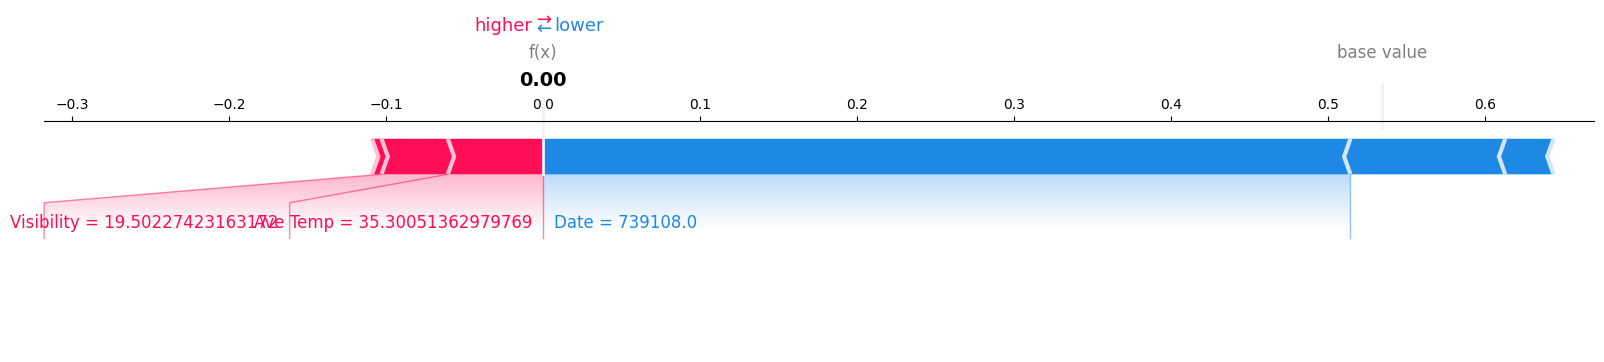


SHAP values for prediction 11:


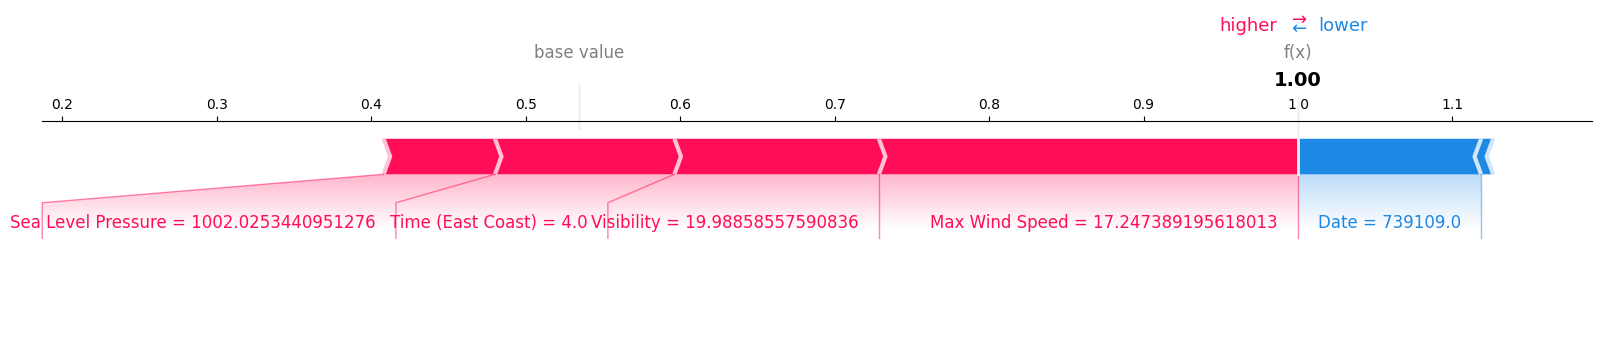


SHAP values for prediction 12:


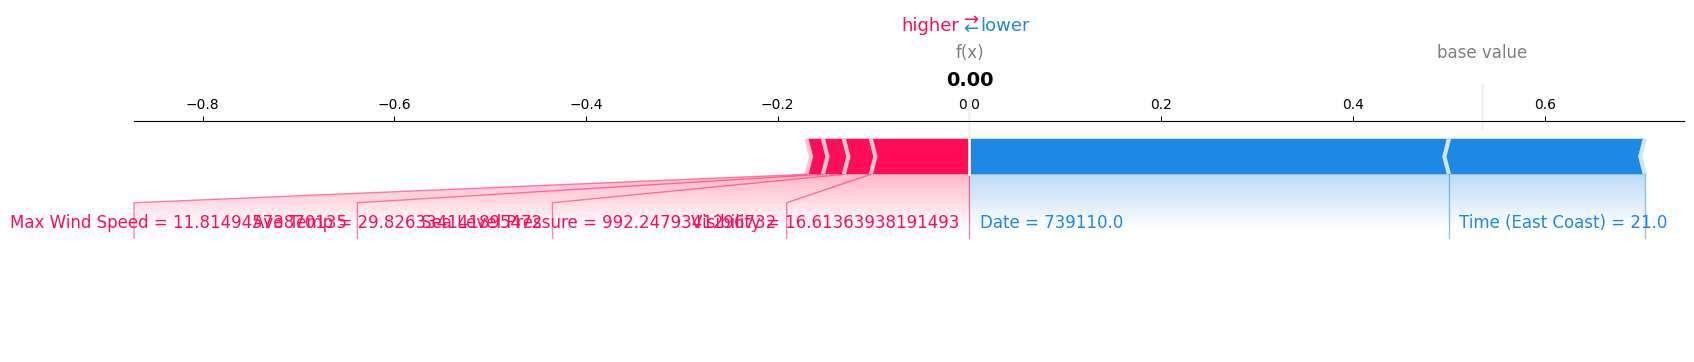


SHAP values for prediction 13:


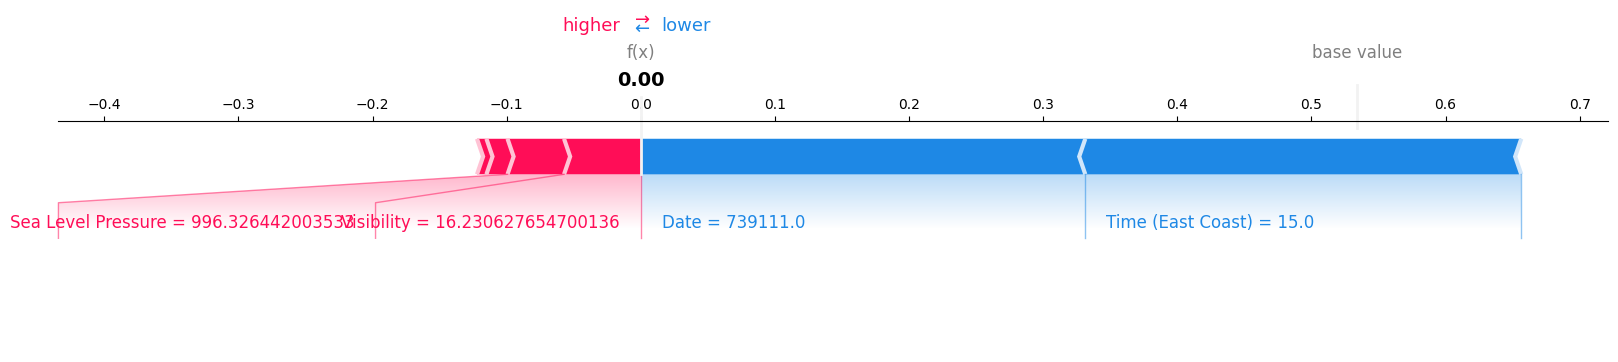


SHAP values for prediction 14:


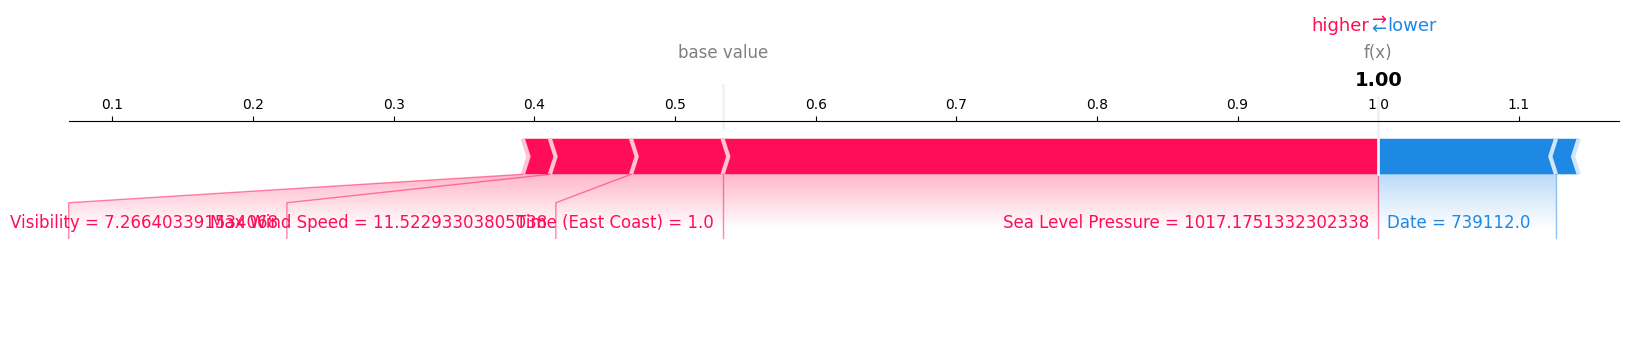


SHAP values for prediction 15:


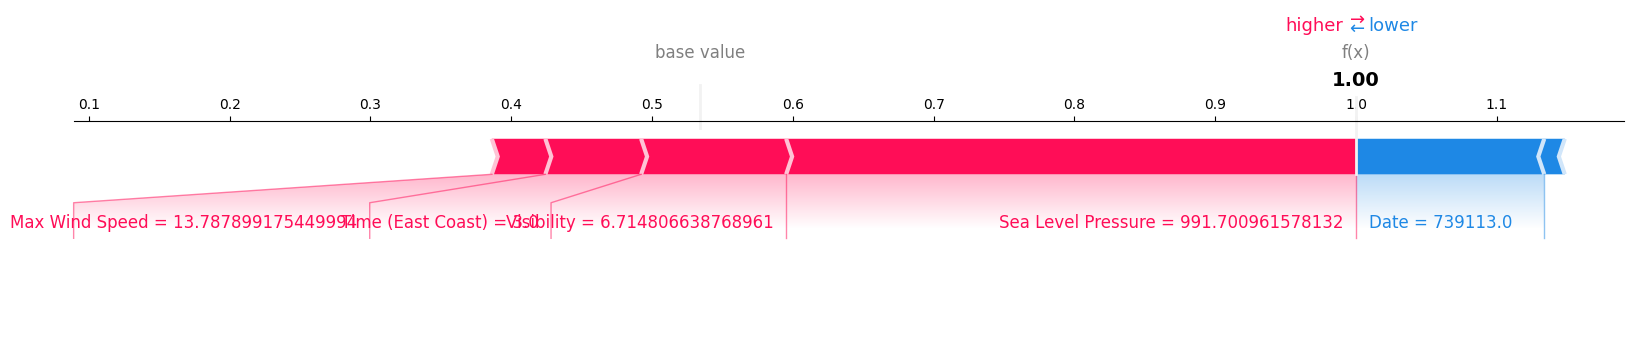

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import shap

# Load existing data for training the model
df = pd.read_csv('/content/drive/MyDrive/DRDO/Extend_Encoded.csv')

# Check the initial data
print("Initial Data:")
print(df.head())

# Convert 'Launched?' column to binary and drop rows with NaN in 'Launched?'
df['Launched?'] = df['Launched?'].map({'Y': 1, 'N': 0})
df = df.dropna(subset=['Launched?'])

# Define a function to parse dates
def parse_date(date):
    for fmt in ('%d-%b-%y', '%d-%b-%Y', '%Y-%m-%d'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Convert 'Date' to numeric ordinal
df['Date'] = df['Date'].apply(parse_date).apply(lambda x: x.toordinal() if pd.notnull(x) else None)

# Convert 'Time (East Coast)' to hours
df['Time (East Coast)'] = pd.to_datetime(df['Time (East Coast)'], format='%H:%M', errors='coerce').dt.hour

# Debug print to check the data after date and time conversion
print("Data after date and time conversion:")
print(df.head())

# Drop rows with NaT in Date or Time columns (if any) after conversion
df.dropna(subset=['Date', 'Time (East Coast)'], inplace=True)

# Debug print to check the preprocessed data
print("Preprocessed Data:")
print(df.head())

# Selecting relevant features
features = ['Date', 'Time (East Coast)', 'Ave Temp', 'Max Wind Speed', 'Visibility', 'Sea Level Pressure']
target = 'Launched?'

# Preparing feature and target variables
X = df[features]
y = df[target]

# Debug print to check X and y
print("Features (X):")
print(X.head())
print("Target (y):")
print(y.head())

# Ensure there are no missing values in X and y
print("Missing values in X:")
print(X.isnull().sum())
print("Missing values in y:")
print(y.isnull().sum())

# Splitting the data
if not X.empty and not y.empty:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check sizes of the splits
    print("Training set size:", X_train.shape, y_train.shape)
    print("Test set size:", X_test.shape, y_test.shape)

    # Train Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Load your new data from the specified path
    df_new = pd.read_csv('/content/drive/MyDrive/DRDO/launch_prediction_input.csv')

    # Drop the 'Percipitation at Launch Time' column
    df_new.drop(columns=['Percipitation at Launch Time'], inplace=True)

    # Debug print to check the new data
    print("New Data:")
    print(df_new.head())

    # Ensure new data contains only the features the model was trained on
    df_new_features = df_new[features]

    # Predictions on the new data
    if not df_new_features.empty:
        predictions = clf.predict(df_new_features)

        # Add predictions to the new dataframe
        df_new['Predictions'] = predictions

        # Print predictions with message indicating if the rocket can be launched
        for index, row in df_new.iterrows():
            can_launch = "Yes" if row['Predictions'] == 1 else "No"
            print(f"Date: {row['Date']}, Time: {row['Time (East Coast)']}, Can Launch: {can_launch}")

        # Explainable AI (XAI) with SHAP
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(df_new_features)

        # Visualize the SHAP values for each prediction
        shap.initjs()
        for i in range(len(df_new)):
            print(f"\nSHAP values for prediction {i + 1}:")
            shap.force_plot(explainer.expected_value[1], shap_values[1][i], df_new_features.iloc[i], matplotlib=True)
    else:
        print("Error: No new data available after preprocessing.")
else:
    print("Error: No data available after preprocessing.")
